
## 03. Pseudoinverse solution + CNN denoising
This tutorial shows how to simulate measurements and perform image reconstruction
using PinvNet (pseudoinverse linear network) with CNN denoising as a last layer.
*  a CNN denoiser instead of the identity operator in order to remove artefacts.
* The measurement operator is chosen as a Hadamard matrix .


#### Load a batch of images



Shape of input images: torch.Size([7, 1, 64, 64])


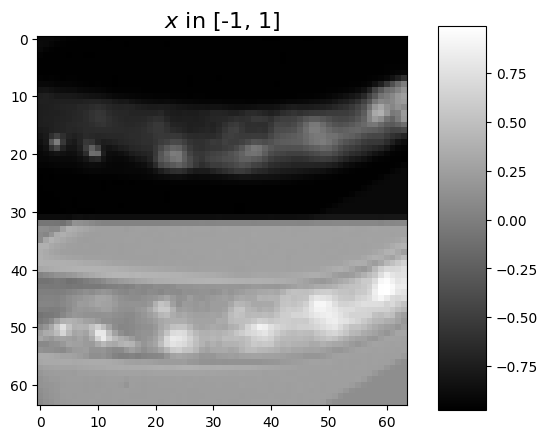

In [1]:

import os
from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch
from spyrit.misc.disp import imagesc

h = 64  
i = 1 
spyritPath = os.getcwd()
imgs_path = os.path.join(spyritPath, "../images")
transform = transform_gray_norm(img_size=h)
dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i : i + 1, :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

####  measurement operator -> Hadamard matrix



Shape of the measurement matrix: (1024, 4096)


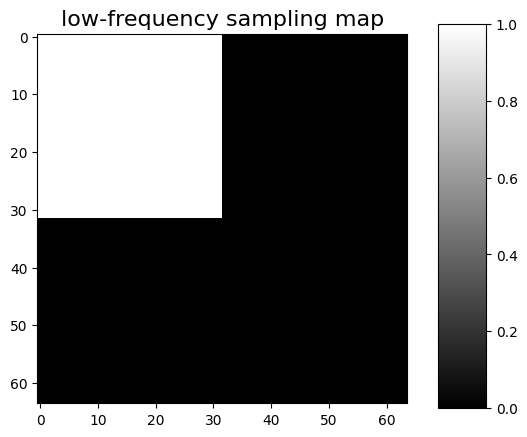

In [2]:
import numpy as np
import math
from spyrit.misc.sampling import Permutation_Matrix
from spyrit.misc.walsh_hadamard import walsh2_matrix

F = walsh2_matrix(h)
F = np.where(F > 0, F, 0)
und = 4  # undersampling factor
M = h**2 // und  # number of measurements (undersampling factor = 4)

Sampling_map = np.ones((h, h))
M_xy = math.ceil(M**0.5)
Sampling_map[:, M_xy:] = 0
Sampling_map[M_xy:, :] = 0

Perm = Permutation_Matrix(Sampling_map)
F = Perm @ F
H = F[:M, :]
print(f"Shape of the measurement matrix: {H.shape}")

imagesc(Sampling_map, "low-frequency sampling map")

In [9]:
from spyrit.core.meas import Linear

meas_op = Linear(H, pinv=True)
# noiseless case 
from spyrit.core.noise import NoNoise
from spyrit.core.prep import DirectPoisson
from spyrit.core.noise import NoNoise
N0 = 1.0  # Noise level (noiseless)
noise = NoNoise(meas_op)

# Simulate measurements
y = noise(x.view(b * c, h * w))
print(f"Shape of raw measurements: {y.shape}")


N0 = 1.0  # Noise level (noiseless)
noise = NoNoise(meas_op)

# Simulate measurements
y = noise(x.view(b * c, h * w))
print(f"Shape of raw measurements: {y.shape}")

# We now compute and plot the preprocessed measurements corresponding to an image in [-1,1]


prep = DirectPoisson(N0, meas_op)  # "Undo" the NoNoise operator

m = prep(y)
print(f"Shape of the preprocessed measurements: {m.shape}")


Shape of raw measurements: torch.Size([1, 1024])
Shape of raw measurements: torch.Size([1, 1024])
Shape of the preprocessed measurements: torch.Size([1, 1024])


Shape of the preprocessed measurement image: (64, 64)


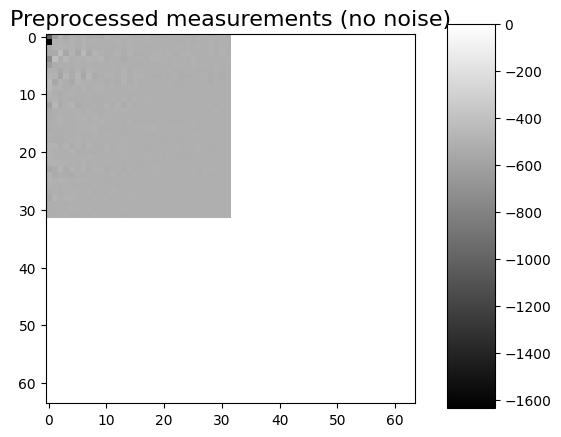

In [10]:
# plot
from spyrit.misc.sampling import meas2img

m_plot = m.detach().numpy().squeeze()
m_plot = meas2img(m_plot, Sampling_map)
print(f"Shape of the preprocessed measurement image: {m_plot.shape}")

imagesc(m_plot, "Preprocessed measurements (no noise)")

#### PinvNet Network



In [11]:
from spyrit.core.recon import PinvNet

pinv_net = PinvNet(noise, prep, denoi=torch.nn.Identity())
pinv_net = PinvNet(noise, prep)
x_rec = pinv_net.reconstruct(y)

#### Removing artefacts with a CNN
* done using  neural network denoiser(last layer of PinvNet)



In [12]:
from spyrit.misc.disp import imagesc
from spyrit.core.nnet import ConvNet, Unet
from spyrit.core.train import load_net

# Define PInvNet with ConvNet denoising layer
denoi = ConvNet()
pinv_net_cnn = PinvNet(noise, prep, denoi)

# Send to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pinv_net_cnn = pinv_net_cnn.to(device)


We download the pretrained weights and load them into the network.



In [13]:
# Load pretrained model
try:
    import gdown

    pretrained_model_num = 3
    if pretrained_model_num == 1:
        # 1 epoch
        url_cnn = "https://drive.google.com/file/d/1iGjxOk06nlB5hSm3caIfx0vy2byQd-ZC/view?usp=drive_link"
        name_cnn = "pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_1_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07"
        num_epochs = 1
    elif pretrained_model_num == 2:
        # 5 epochs
        url_cnn = "https://drive.google.com/file/d/1tzZg1lU3AxOi8-EVXFgnxdtqQCJPjQ9f/view?usp=drive_link"
        name_cnn = (
            "pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_5_lr_0.001_sss_10_sdr_0.5_bs_512"
        )
        num_epochs = 5
    elif pretrained_model_num == 3:
        # 30 epochs
        url_cnn = "https://drive.google.com/file/d/1IZYff1xQxJ3ckAnObqAWyOure6Bjkj4k/view?usp=drive_link"
        name_cnn = "pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07"
        num_epochs = 30

    # Create model folder
    model_path = "./model"
    if os.path.exists(model_path) is False:
        os.mkdir(model_path)
        print(f"Created {model_path}")

    # Download model weights
    model_cnn_path = os.path.join(model_path, name_cnn)
    gdown.download(url_cnn, f"{model_cnn_path}.pth", quiet=False, fuzzy=True)

    # Load model weights
    load_net(model_cnn_path, pinv_net_cnn, device, False)
    print(f"Model {model_path} loaded.")
except:
    print(f"Model {model_path} not found!")

Downloading...
From (original): https://drive.google.com/uc?id=1IZYff1xQxJ3ckAnObqAWyOure6Bjkj4k
From (redirected): https://drive.google.com/uc?id=1IZYff1xQxJ3ckAnObqAWyOure6Bjkj4k&confirm=t&uuid=cb68f671-e8b0-4acc-bd04-d76ab2786aa0
To: c:\Users\RAmsh\OneDrive\Desktop\gjbhjbkhb\spyrit-master\spyrit\tutorial\model\pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07.pth
100%|██████████| 50.4M/50.4M [00:18<00:00, 2.74MB/s]

Model Loaded: ./model\pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07
Model ./model loaded.


We now reconstruct the image using PinvNet with pretrained CNN denoising
and plot results side by side with the PinvNet without denoising



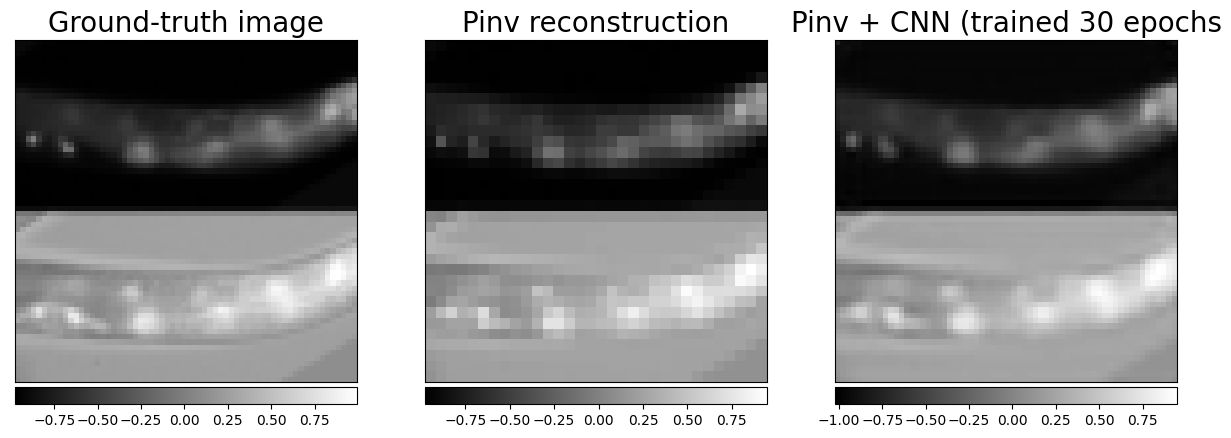

In [14]:
with torch.no_grad():
    x_rec_cnn = pinv_net_cnn.reconstruct(y.to(device))
    x_rec_cnn = pinv_net_cnn(x.to(device))

# plot
x_plot = x.squeeze().cpu().numpy()
x_plot2 = x_rec.squeeze().cpu().numpy()
x_plot3 = x_rec_cnn.squeeze().cpu().numpy()

import matplotlib.pyplot as plt
from spyrit.misc.disp import add_colorbar, noaxis

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(x_plot, cmap="gray")
ax1.set_title("Ground-truth image", fontsize=20)
noaxis(ax1)
add_colorbar(im1, "bottom", size="20%")

im2 = ax2.imshow(x_plot2, cmap="gray")
ax2.set_title("Pinv reconstruction", fontsize=20)
noaxis(ax2)
add_colorbar(im2, "bottom", size="20%")

im3 = ax3.imshow(x_plot3, cmap="gray")
ax3.set_title(f"Pinv + CNN (trained {num_epochs} epochs", fontsize=20)
noaxis(ax3)
add_colorbar(im3, "bottom", size="20%")

In [15]:
import numpy as np

# Calculate signal power (total number of photons)
signal_power = torch.sum(x ** 2)  # Squared L2 norm of the original signal

# Calculate noise power for each reconstructed image
noise_power_rec = torch.sum((x - x_rec) ** 2)  # Squared L2 norm of the difference
noise_power_rec_cnn = torch.sum((x - x_rec_cnn) ** 2)  # Squared L2 norm of the difference

# Calculate SNR for each reconstructed image
SNR_rec = 10 * torch.log10(signal_power / noise_power_rec)
SNR_rec_cnn = 10 * torch.log10(signal_power / noise_power_rec_cnn)

print("SNR for reconstruction (without CNN):", SNR_rec.item())
print("SNR for reconstruction (with CNN):", SNR_rec_cnn.item())


SNR for reconstruction (without CNN): 21.708538055419922
SNR for reconstruction (with CNN): 26.068944931030273
